In [1]:
from ganpaint import renormalize, imgviz, nethook, pbar
import torch, torchvision
torch.backends.cudnn.benchmark = True
torch.set_grad_enabled(False)

In [12]:
net = nethook.InstrumentedModel(torchvision.models.resnet18(pretrained=True)).cuda()
net.eval()
net.layer_names()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /afs/csail.mit.edu/u/d/davidbau/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.6MB/s]


['',
 'conv1',
 'bn1',
 'relu',
 'maxpool',
 'layer1',
 'layer1.0',
 'layer1.0.conv1',
 'layer1.0.bn1',
 'layer1.0.relu',
 'layer1.0.conv2',
 'layer1.0.bn2',
 'layer1.1',
 'layer1.1.conv1',
 'layer1.1.bn1',
 'layer1.1.relu',
 'layer1.1.conv2',
 'layer1.1.bn2',
 'layer2',
 'layer2.0',
 'layer2.0.conv1',
 'layer2.0.bn1',
 'layer2.0.relu',
 'layer2.0.conv2',
 'layer2.0.bn2',
 'layer2.0.downsample',
 'layer2.0.downsample.0',
 'layer2.0.downsample.1',
 'layer2.1',
 'layer2.1.conv1',
 'layer2.1.bn1',
 'layer2.1.relu',
 'layer2.1.conv2',
 'layer2.1.bn2',
 'layer3',
 'layer3.0',
 'layer3.0.conv1',
 'layer3.0.bn1',
 'layer3.0.relu',
 'layer3.0.conv2',
 'layer3.0.bn2',
 'layer3.0.downsample',
 'layer3.0.downsample.0',
 'layer3.0.downsample.1',
 'layer3.1',
 'layer3.1.conv1',
 'layer3.1.bn1',
 'layer3.1.relu',
 'layer3.1.conv2',
 'layer3.1.bn2',
 'layer4',
 'layer4.0',
 'layer4.0.conv1',
 'layer4.0.bn1',
 'layer4.0.relu',
 'layer4.0.conv2',
 'layer4.0.bn2',
 'layer4.0.downsample',
 'layer4.0.down

In [13]:
from ganpaint import parallelfolder
g_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(256),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

ds = parallelfolder.ParallelImageFolders(
    ['/data/vision/torralba/datasets/mini-imagenet/images'],
    transform=g_transform,
    shuffle=True)

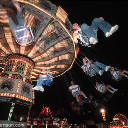

In [14]:
iv = imgviz.ImageVisualizer(128)
iv.image(ds[88][0])

1. Test the encoder on a specific arbitrary dataset training image.
2. For a designated feature layer, render a heatmap for a specific arbitrary feature channel on that channel.
3. Get 1000 training set images into "img_sample", and
4. Collect featuremaps from the feature layer into the "f_sample" tensor.

example feature - image 0, unit 0


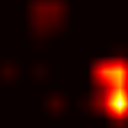

Loading a sample of images



Building a tensor of all features over images



Creating whitened version of features
Done.


In [17]:
from torch.utils.data import DataLoader
from ganpaint import runningstats

def load_image_set(dataset, size=10000):
    # Equivalent: img_sample = torch.cat([dataset[i][0][None] for i in pbar(range(10000))])
    # Batching reads with DataLoader helps us do multithreaded disk access.
    load_batch_size = 100
    img_sample = torch.cat([batch[0] for batch, i in zip(
        DataLoader(dataset, batch_size=load_batch_size, num_workers=20),
        pbar(range(-(-size // load_batch_size))))])[:size]
    return img_sample

def create_feature_set(feature_fn, img_sample):
    compute_batch_size = 32
    f_sample = torch.cat([
        feature_fn(img_sample[i:i+compute_batch_size])
            for i in pbar(range(0, len(img_sample), compute_batch_size))])
    return f_sample

net.retain_layer('layer4')
def feature_fn(img_batch):
    net(img_batch.cuda())
    return net.retained_layer('layer4').cpu()

def feature_unit_heatmap(feature_fn, dataset, image_number=0, unit_number=0):
    return iv.heatmap(feature_fn(dataset[image_number][0][None].cuda())[0,unit_number])

print("example feature - image 0, unit 0")
display(feature_unit_heatmap(feature_fn, ds))

print("Loading a sample of images")
img_sample = load_image_set(ds)

print("Building a tensor of all features over images")
f_sample = create_feature_set(feature_fn, img_sample)

print("Collecting covariance of the features")
cv = runningstats.RunningCovariance()
cv.add(f_sample.permute(0, 2, 3, 1).contiguous().view(-1, f_sample.shape[1]))

print("Creating whitened version of features")
whitener = cv.covariance().inverse()
def whiten(data):
    return torch.matmul(data.permute(0,2,3,1), whitener).permute(0,3,1,2)
f_whitened = whiten(f_sample)

print("Done.")

Below, an interactive visualization.

Every time you click on the image, it:
1. finds patches in the 1000 sampled images that best match your selected features.
2. displays the images with those patches, with best-matching patches highlighted.

Click me



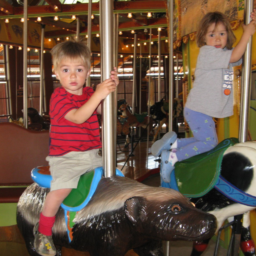
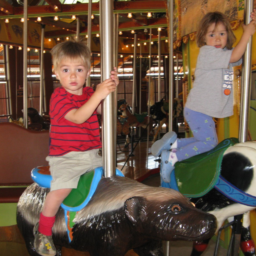

In [20]:
from ganpaint import show
from ganpaint.labwidget import Div, Model, Property, Button, Textbox
from ganpaint.paintwidget import PaintWidget


class ImageFeatureExplorer(Model):
    def __init__(self, samplenums, f_sample, img_sample):
        self.samplenums = Property(','.join(str(n) for n in samplenums))
        self.feature_fn = Property(feature_fn)
        self.query_f = Property(None)
        self.sampleTextbox = Textbox(self.prop('samplenums'))
        self.img_sample = img_sample
        self.f_sample = f_sample
        self.on('samplenums', self.redisplay_painters)
        self.painters = []
        self.resetButton = Button('reset')
        self.inputs = Div()
        self.results = Div()
        self.redisplay_painters()
        self.recompute_results()
        self.resetButton.on('click', self.reset_painters)
        self.on('query_f', self.recompute_results)
        
    def get_samplenums(self):
        result = []
        for s in self.samplenums.split(','):
            try:
                result.append(int(s.strip()))
            except:
                pass
        return result
        
    def redisplay_painters(self):
        samplenums = self.get_samplenums()
        self.painters = [
            PaintWidget(self.img_sample.shape[3], self.img_sample.shape[2],
                        brushsize=5, image=renormalize.as_url(self.img_sample[i]))
            for i in samplenums]
        for p in self.painters:
            p.on('mask', self.recompute_query)
        self.inputs.innerHTML = show.html([self.sampleTextbox, [[p] for p in self.painters] + [[self.resetButton]]])
    
    def reset_painters(self):
        for p in self.painters:
            p.mask = ''
    
    def recompute_query(self):
        global feat
        total_mask = 0.0
        total_feat = torch.zeros_like(f_sample[0,:,0,0])
        for i, p in zip(self.get_samplenums(), self.painters):
            a = self.f_sample[i]
            if p.mask:
                mask = renormalize.from_url(
                    p.mask, target='pt', size=a.shape[1:])[0]
                total_feat = total_feat + (a * mask[None]).sum((1,2))
                total_mask += mask.sum()
        feat = total_feat / (total_mask + 1e-20)
        self.query_f = feat
    
    def recompute_results(self):
        if self.query_f is None:
            return
        feat = self.query_f
        # Rank the sampled images according to similar to this feature
        patch_scores = (self.f_sample * feat[None,:,None,None]).sum(1)
        score = patch_scores.view(len(f_sample), -1).max(1)[0]
        _, ordering = torch.sort(-score)
        self.results.innerHTML = show.html([
            ['img #%d' % i.item(), 
             'score %g' % score[i].item(),
             [
                iv.masked_image(
                    self.img_sample[i],
                    (self.f_sample[i] * feat[None,:,None,None]).sum(1)[0],
                    percent_level=0.9)
            ]] for i in ordering[:14]
        ])
        
    def _repr_html_(self):
        return self.inputs._repr_html_() + self.results._repr_html_()

explorer = ImageFeatureExplorer([290], f_whitened, img_sample)
print('Click me')
display(explorer)


f = explorer.query_f
a = torch.zeros

In [7]:
explorer.query_f